In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

df = pd.read_csv("homelens_temsili_veri.csv")
df.head()


,Semt,Oda_Sayisi,Metrekare,Bina_Yasi,Kat,Isitma,Site_Icinde,Esyali,Asansor,Balkon,Manzara,Aidat,Kira
0,Karşıyaka,2+1,142,17,4,Klima,Evet,Hayır,Evet,Evet,Şehir,243,34156
1,Bayraklı,2+1,111,14,1,Klima,Evet,Evet,Hayır,Evet,Şehir,584,22746
2,Bornova,1+1,139,10,1,Doğalgaz Kombi,Hayır,Evet,Evet,Evet,Deniz,211,28713
3,Konak,2+1,112,13,3,Klima,Hayır,Hayır,Hayır,Hayır,Yok,721,22354
4,Bornova,1+1,114,19,3,Doğalgaz Kombi,Evet,Evet,Evet,Evet,Deniz,55,26047


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Semt         500 non-null    object
 1   Oda_Sayisi   500 non-null    object
 2   Metrekare    500 non-null    int64 
 3   Bina_Yasi    500 non-null    int64 
 4   Kat          500 non-null    int64 
 5   Isitma       500 non-null    object
 6   Site_Icinde  500 non-null    object
 7   Esyali       500 non-null    object
 8   Asansor      500 non-null    object
 9   Balkon       500 non-null    object
 10  Manzara      500 non-null    object
 11  Aidat        500 non-null    int64 
 12  Kira         500 non-null    int64 
dtypes: int64(5), object(8)
memory usage: 50.9+ KB


In [22]:
print(df.isnull().sum())

Semt           0
Oda_Sayisi     0
Metrekare      0
Bina_Yasi      0
Kat            0
Isitma         0
Site_Icinde    0
Esyali         0
Asansor        0
Balkon         0
Manzara        0
Aidat          0
Kira           0
dtype: int64


In [23]:
X = df.drop("Kira", axis=1)
y = df["Kira"]


In [24]:
print(X.dtypes)

Semt           object
Oda_Sayisi     object
Metrekare       int64
Bina_Yasi       int64
Kat             int64
Isitma         object
Site_Icinde    object
Esyali         object
Asansor        object
Balkon         object
Manzara        object
Aidat           int64
dtype: object


In [25]:
sayisal_sutunlar = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_sutunlar = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Sayısal sütunlar:", sayisal_sutunlar)
print("Kategorik sütunlar:", kategorik_sutunlar)


Sayısal sütunlar: ['Metrekare', 'Bina_Yasi', 'Kat', 'Aidat']
Kategorik sütunlar: ['Semt', 'Oda_Sayisi', 'Isitma', 'Site_Icinde', 'Esyali', 'Asansor', 'Balkon', 'Manzara']


In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), kategorik_sutunlar)
    ],
    remainder="passthrough"
)


In [27]:
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBRegressor(random_state=42, objective='reg:squarederror'))
])

param_grid = {
    "model__n_estimators": [50, 100],
    "model__max_depth": [3, 6],
    "model__learning_rate": [0.1, 0.01]
}


In [28]:
gs = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs.fit(X, y)

print("En iyi RMSE:", np.sqrt(-gs.best_score_))
print("En iyi parametreler:", gs.best_params_)


En iyi RMSE: 884.8610696035847
En iyi parametreler: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}


In [29]:
def plot_learning_curve(estimator, X, y, title):
    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_rmse.mean(axis=1), label='Training RMSE')
    plt.plot(train_sizes, val_rmse.mean(axis=1), label='Validation RMSE')
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()


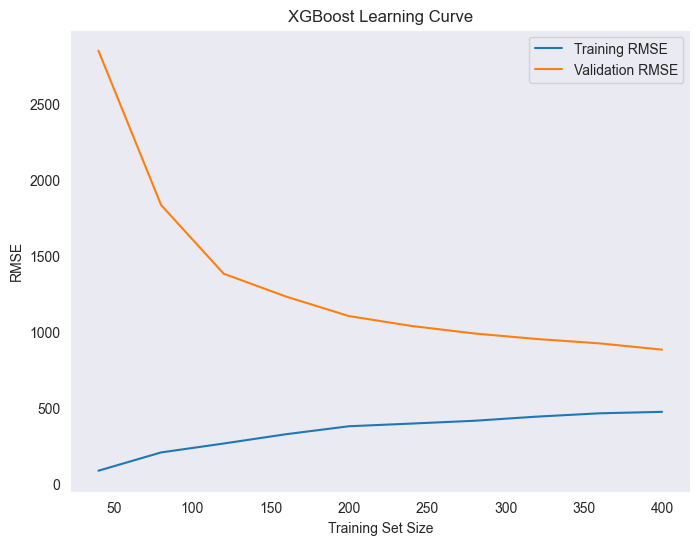

In [30]:
plot_learning_curve(gs.best_estimator_, X, y, "XGBoost Learning Curve")


In [32]:
best_xgb_model = gs.best_estimator_  # XGBoost GridSearch sonucu
joblib.dump(best_xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']